In [196]:
import logging
import os 
import random
from functools import partial

import torch
from PIL import ImageFilter
from torchvision import datasets, transforms
from torchvision.models import resnet 
from tqdm import tqdm 
import numpy as np

from pytorch_metric_learning import losses
from pytorch_metric_learning.utils import logging_presets

logging.getLogger().setLevel(logging.INFO)

device = torch.device("cuda")

In [197]:
MEAN = [0.47365573, 0.4402452, 0.38663769]
STD = [0.26914782, 0.26083042, 0.2624779]

In [198]:
normalize = transforms.Normalize(MEAN, STD)
val_transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), normalize])
val_dir = 'data/Daniel_Shan_Balico/validation/'
train_dataset_for_eval = datasets.ImageFolder(
        val_dir, transform=val_transform
    )
train_loader_for_eval = torch.utils.data.DataLoader(
        train_dataset_for_eval,
        batch_size=256,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        drop_last=False,
    )

In [199]:
model_dict = torch.load('trained_models/March_29_200_48.25.pth')

In [200]:
class SplitBatchNorm(torch.nn.BatchNorm2d):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            running_mean_split = self.running_mean.repeat(self.num_splits)
            running_var_split = self.running_var.repeat(self.num_splits)
            outcome = torch.nn.functional.batch_norm(
                input.view(-1, C * self.num_splits, H, W),
                running_mean_split,
                running_var_split,
                self.weight.repeat(self.num_splits),
                self.bias.repeat(self.num_splits),
                True,
                self.momentum,
                self.eps,
            ).view(N, C, H, W)
            self.running_mean.data.copy_(
                running_mean_split.view(self.num_splits, C).mean(dim=0)
            )
            self.running_var.data.copy_(
                running_var_split.view(self.num_splits, C).mean(dim=0)
            )
            return outcome
        else:
            return torch.nn.functional.batch_norm(
                input,
                self.running_mean,
                self.running_var,
                self.weight,
                self.bias,
                False,
                self.momentum,
                self.eps,
            )
        
class ModelBase(torch.nn.Module):
    """
    Common CIFAR ResNet recipe.
    Comparing with ImageNet ResNet recipe, it:
    (i) replaces conv1 with kernel=3, str=1
    (ii) removes pool1
    """

    def __init__(self, feature_dim=128, arch="resnet18", bn_splits=8):
        super(ModelBase, self).__init__()

        # use split batchnorm
        norm_layer = (
            partial(SplitBatchNorm, num_splits=bn_splits)
            if bn_splits > 1
            else torch.nn.BatchNorm2d
        )
        resnet_arch = getattr(resnet, arch)
        net = resnet_arch(num_classes=feature_dim, norm_layer=norm_layer)

        self.net = []
        for name, module in net.named_children():
            if name == "conv1":
                module = torch.nn.Conv2d(
                    3, 64, kernel_size=3, stride=1, padding=1, bias=False
                )
            if isinstance(module, torch.nn.MaxPool2d):
                continue
            if isinstance(module, torch.nn.Linear):
                self.net.append(torch.nn.Flatten(1))
            self.net.append(module)

        self.net = torch.nn.Sequential(*self.net)

    def forward(self, x):
        x = self.net(x)
        # note: not normalized here
        return x

In [201]:
model = ModelBase()
model = torch.nn.DataParallel(model)
model.load_state_dict(model_dict)
model.to(device)

DataParallel(
  (module): ModelBase(
    (net): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): SplitBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): SplitBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): SplitBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): SplitBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu):

In [215]:
all_features = []
test_bar = tqdm(train_loader_for_eval)
for data, target in test_bar:
    #data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
    feature = model(data)
    feature = torch.nn.functional.normalize(feature, dim=1)
    feature = feature[:, :-1]
    all_features.append(feature)

100%|██████████| 2/2 [00:00<00:00,  3.07it/s]


In [216]:
all_features[0].size()

torch.Size([256, 127])

In [217]:
all_features = torch.cat(all_features)

In [218]:
all_features.shape
all_features = all_features.cpu()

In [246]:
from sklearn.manifold import TSNE

# Reduce dimensionality to 2 for visualization (you can adjust)
tsne = TSNE(n_components=2, perplexity=350)  # Adjust perplexity as needed
reduced_features = tsne.fit_transform(all_features.detach().numpy())

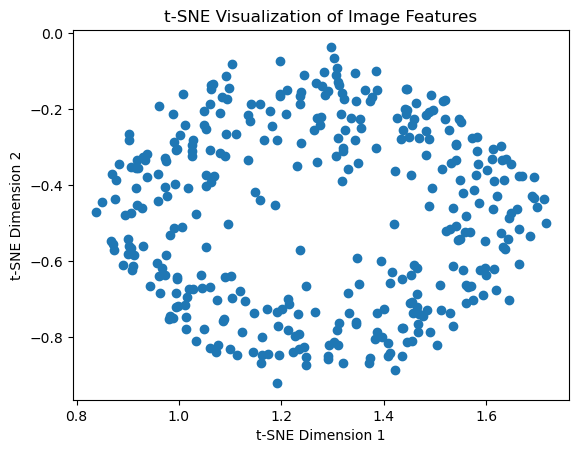

In [247]:
import matplotlib.pyplot as plt

plt.scatter(reduced_features[:, 0], reduced_features[:, 1])
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Image Features")
plt.show()